# Assignment 6
```Berle, Bastian```, ```Holzapfel, Ron```

Some parts are taken from https://www.kaggle.com/cordmaur/38-cloud-simple-unet and adapted.

## Import

In [1]:
!pip install torchsummary

In [2]:
import time
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from PIL import Image
from IPython.display import clear_output
from torchsummary import summary

### PyTorch

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, sampler

In [4]:
if not torch.cuda.is_available():
  raise Exception("GPU not availalbe. CPU training will be too slow.")

print("device name", torch.cuda.get_device_name(0))

device name Tesla P100-PCIE-16GB


## Settings

In [5]:
STANDARD_PATH = '../input/'

## Data Preparation

In [6]:
class CloudDataset(Dataset):
    def __init__(self, r_dir, g_dir, b_dir, nir_dir, gt_dir=None, pytorch=True):
        super().__init__()
        self.is_test_dataset = (gt_dir == None)
        # Loop through the files in red folder and combine, into a dictionary, the other bands
        self.files = [self.combine_files(f, g_dir, b_dir, nir_dir, gt_dir) for f in r_dir.iterdir() if not f.is_dir()]
        self.pytorch = pytorch
        
    def combine_files(self, r_file: Path, g_dir, b_dir,nir_dir, gt_dir):
        files = {'red': r_file, 
                 'green':g_dir/r_file.name.replace('red', 'green'),
                 'blue': b_dir/r_file.name.replace('red', 'blue'), 
                 'nir': nir_dir/r_file.name.replace('red', 'nir')}
        if not self.is_test_dataset:
            files['gt'] = gt_dir/r_file.name.replace('red', 'gt')
        return files
                                       
    def __len__(self):
        return len(self.files)
     
    # create array from individual layers
    def open_as_array(self, idx, invert=False, include_nir=False):
        raw_rgb = np.stack([np.array(Image.open(self.files[idx]['red'])),
                            np.array(Image.open(self.files[idx]['green'])),
                            np.array(Image.open(self.files[idx]['blue'])),
                           ], axis=2)
        if include_nir:
            nir = np.expand_dims(np.array(Image.open(self.files[idx]['nir'])), 2)
            raw_rgb = np.concatenate([raw_rgb, nir], axis=2)
        if invert:
            raw_rgb = raw_rgb.transpose((2,0,1))
        # normalize
        return (raw_rgb / np.iinfo(raw_rgb.dtype).max)
    
    def open_mask(self, idx, add_dims=False):
        raw_mask = np.array(Image.open(self.files[idx]['gt']))
        raw_mask = np.where(raw_mask==255, 1, 0)
        return np.expand_dims(raw_mask, 0) if add_dims else raw_mask
    
    def __getitem__(self, idx):
        x = torch.tensor(self.open_as_array(idx, invert=self.pytorch, include_nir=True), dtype=torch.float32)
        if not self.is_test_dataset:
            y = torch.tensor(self.open_mask(idx, add_dims=False), dtype=torch.torch.int64)
            return x, y
        else:
            return x

In [7]:
# create datasets
base_path_train = Path(STANDARD_PATH + '38cloud-cloud-segmentation-in-satellite-images/38-Cloud_training')
base_path_test = Path(STANDARD_PATH + '38cloud-cloud-segmentation-in-satellite-images/38-Cloud_test')
train_data = CloudDataset(base_path_train/'train_red', 
                    base_path_train/'train_green', 
                    base_path_train/'train_blue', 
                    base_path_train/'train_nir',
                    base_path_train/'train_gt')
test_data = CloudDataset(base_path_test/'test_red', 
                    base_path_test/'test_green', 
                    base_path_test/'test_blue', 
                    base_path_test/'test_nir')
len(train_data), len(test_data)

(8400, 9201)

In [8]:
train_ds, valid_ds = torch.utils.data.random_split(train_data, (6000, 2400))

In [9]:
batch_size = 25
dataloaders = {
    'train': DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=0),
    'val': DataLoader(valid_ds, batch_size=batch_size, shuffle=True, num_workers=0),
    'test': DataLoader(test_data, batch_size=batch_size, shuffle=True, num_workers=0)
}

## Data Exploration

In [10]:
# get shape of one example
x, y = train_data[3003]
x.shape, y.shape

(torch.Size([4, 384, 384]), torch.Size([384, 384]))

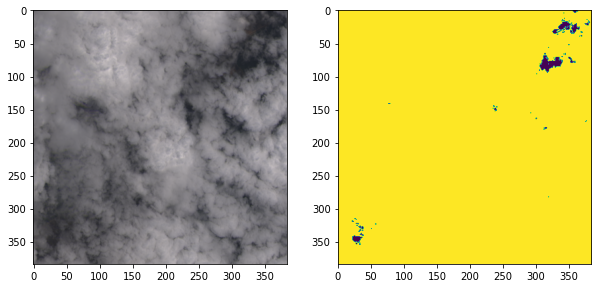

In [11]:
# visualize one example
fig, ax = plt.subplots(1,2, figsize=(10,9))
ax[0].imshow(train_data.open_as_array(3003))
ax[1].imshow(train_data.open_mask(3003))

In [12]:
# get shape of one batch
xb, yb = next(iter(dataloaders['train']))
xb.shape, yb.shape

(torch.Size([25, 4, 384, 384]), torch.Size([25, 384, 384]))

## Creating U-Net

In [13]:
from torch import nn
class UNET(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()

        self.conv1 = self.contract_block(in_channels, 32, 7, 3)
        self.conv2 = self.contract_block(32, 64, 3, 1)
        self.conv3 = self.contract_block(64, 128, 3, 1)

        self.upconv3 = self.expand_block(128, 64, 3, 1)
        self.upconv2 = self.expand_block(64*2, 32, 3, 1)
        self.upconv1 = self.expand_block(32*2, out_channels, 3, 1)

    def __call__(self, x):

        # downsampling part
        conv1 = self.conv1(x)
        conv2 = self.conv2(conv1)
        conv3 = self.conv3(conv2)

        upconv3 = self.upconv3(conv3)

        upconv2 = self.upconv2(torch.cat([upconv3, conv2], 1))
        upconv1 = self.upconv1(torch.cat([upconv2, conv1], 1))

        return upconv1

    def contract_block(self, in_channels, out_channels, kernel_size, padding):

        contract = nn.Sequential(
            torch.nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, stride=1, padding=padding),
            torch.nn.BatchNorm2d(out_channels),
            torch.nn.ReLU(),
            torch.nn.Conv2d(out_channels, out_channels, kernel_size=kernel_size, stride=1, padding=padding),
            torch.nn.BatchNorm2d(out_channels),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
                                 )

        return contract

    def expand_block(self, in_channels, out_channels, kernel_size, padding):

        expand = nn.Sequential(torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride=1, padding=padding),
                            torch.nn.BatchNorm2d(out_channels),
                            torch.nn.ReLU(),
                            torch.nn.Conv2d(out_channels, out_channels, kernel_size, stride=1, padding=padding),
                            torch.nn.BatchNorm2d(out_channels),
                            torch.nn.ReLU(),
                            torch.nn.ConvTranspose2d(out_channels, out_channels, kernel_size=3, stride=2, padding=1, output_padding=1) 
                            )
        return expand

In [14]:
def train(model, train_dl, valid_dl, loss_fn, optimizer, acc_fn, epochs=1):
    start = time.time()

    train_loss, valid_loss = [], []

    best_acc = 0.0

    for epoch in range(epochs):
        print('Epoch {}/{}'.format(epoch, epochs - 1))
        print('-' * 10)

        for phase in ['train', 'valid']:
            if phase == 'train':
                model.train(True)  # Set trainind mode = true
                dataloader = train_dl
            else:
                model.train(False)  # Set model to evaluate mode
                dataloader = valid_dl

            running_loss = 0.0
            running_acc = 0.0

            step = 0

            # iterate over data
            for x, y in dataloader:
                x = x.cuda()
                y = y.cuda()
                step += 1

                # forward pass
                if phase == 'train':
                    # zero the gradients
                    optimizer.zero_grad()
                    outputs = model(x)
                    loss = loss_fn(outputs, y)

                    # the backward pass frees the graph memory, so there is no 
                    # need for torch.no_grad in this training pass
                    loss.backward()
                    optimizer.step()
                    # scheduler.step()

                else:
                    with torch.no_grad():
                        outputs = model(x)
                        loss = loss_fn(outputs, y.long())

                # stats - whatever is the phase
                acc = acc_fn(outputs, y)

                running_acc  += acc*dataloader.batch_size
                running_loss += loss*dataloader.batch_size 

                if step % 100 == 0:
                    # clear_output(wait=True)
                    print('Current step: {}  Loss: {}  Acc: {}  AllocMem (Mb): {}'.format(step, loss, acc, torch.cuda.memory_allocated()/1024/1024))
                    # print(torch.cuda.memory_summary())

            epoch_loss = running_loss / len(dataloader.dataset)
            epoch_acc = running_acc / len(dataloader.dataset)

            clear_output(wait=True)
            print('Epoch {}/{}'.format(epoch, epochs - 1))
            print('-' * 10)
            print('{} Loss: {:.4f} Acc: {}'.format(phase, epoch_loss, epoch_acc))
            print('-' * 10)

            train_loss.append(epoch_loss) if phase=='train' else valid_loss.append(epoch_loss)

    time_elapsed = time.time() - start
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))    
    
    return train_loss, valid_loss    

def acc_metric(predb, yb):
    return (predb.argmax(dim=1) == yb.cuda()).float().mean()

In [15]:
model = UNET(4,2).cuda()

In [16]:
summary(model, input_size=(4, 128, 128))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 128, 128]           6,304
       BatchNorm2d-2         [-1, 32, 128, 128]              64
              ReLU-3         [-1, 32, 128, 128]               0
            Conv2d-4         [-1, 32, 128, 128]          50,208
       BatchNorm2d-5         [-1, 32, 128, 128]              64
              ReLU-6         [-1, 32, 128, 128]               0
         MaxPool2d-7           [-1, 32, 64, 64]               0
            Conv2d-8           [-1, 64, 64, 64]          18,496
       BatchNorm2d-9           [-1, 64, 64, 64]             128
             ReLU-10           [-1, 64, 64, 64]               0
           Conv2d-11           [-1, 64, 64, 64]          36,928
      BatchNorm2d-12           [-1, 64, 64, 64]             128
             ReLU-13           [-1, 64, 64, 64]               0
        MaxPool2d-14           [-1, 64,

## Training

In [17]:
loss_fn = nn.CrossEntropyLoss()
opt = optim.Adam(model.parameters(), lr=0.01)
train_loss, valid_loss = train(model, dataloaders['train'], dataloaders['val'], loss_fn, opt, acc_metric, epochs=15)

Epoch 14/14
----------
valid Loss: 0.1143 Acc: 0.9556249976158142
----------
Training complete in 52m 47s


## Evaluation

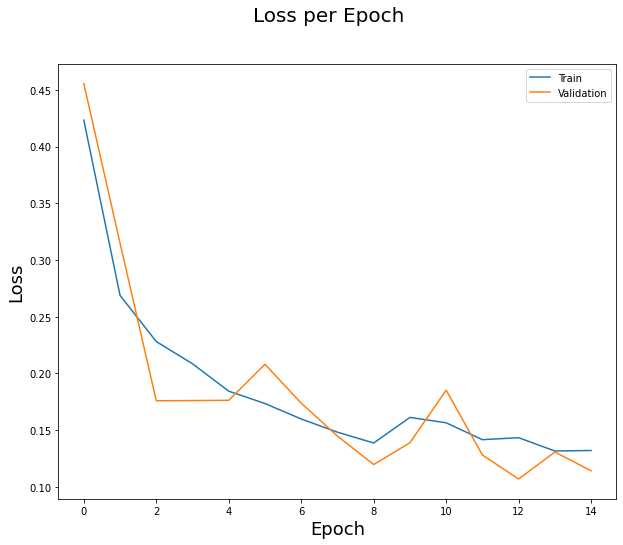

In [18]:
fig = plt.figure(figsize=(10,8))
fig.suptitle('Loss per Epoch', fontsize=20)
plt.xlabel('Epoch', fontsize=18)
plt.ylabel('Loss', fontsize=18)
plt.plot(train_loss, label='Train')
plt.plot(valid_loss, label='Validation')
plt.legend()

### Show Training Examples

In [19]:
def batch_to_img(xb, idx):
    img = np.array(xb[idx,0:3])
    return img.transpose((1,2,0))

def predb_to_mask(predb, idx):
    p = torch.functional.F.softmax(predb[idx], 0)
    return p.argmax(0).cpu()

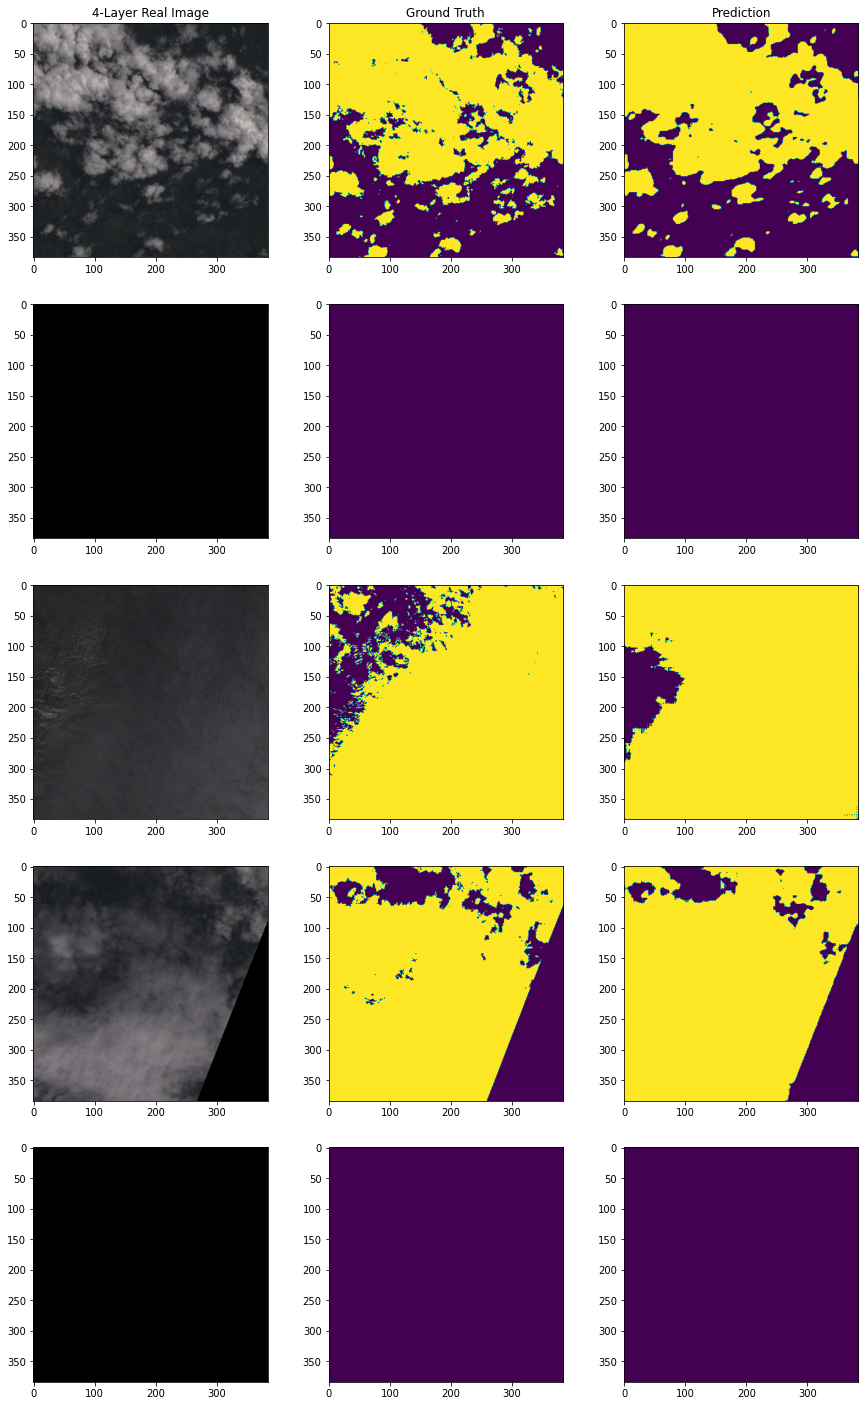

In [20]:
batch_size = 5 # Reduce batch_size to print only five examples
fig, ax = plt.subplots(batch_size, 3, figsize=(15,batch_size*5))

xb, yb = next(iter(dataloaders['train']))

with torch.no_grad():
    predb = model(xb.cuda())

ax[0][0].set_title('4-Layer Real Image')
ax[0][1].set_title('Ground Truth')
ax[0][2].set_title('Prediction')
for i in range(batch_size):
    ax[i,0].imshow(batch_to_img(xb,i))
    ax[i,1].imshow(yb[i])
    ax[i,2].imshow(predb_to_mask(predb, i))

### Show Test Examples 

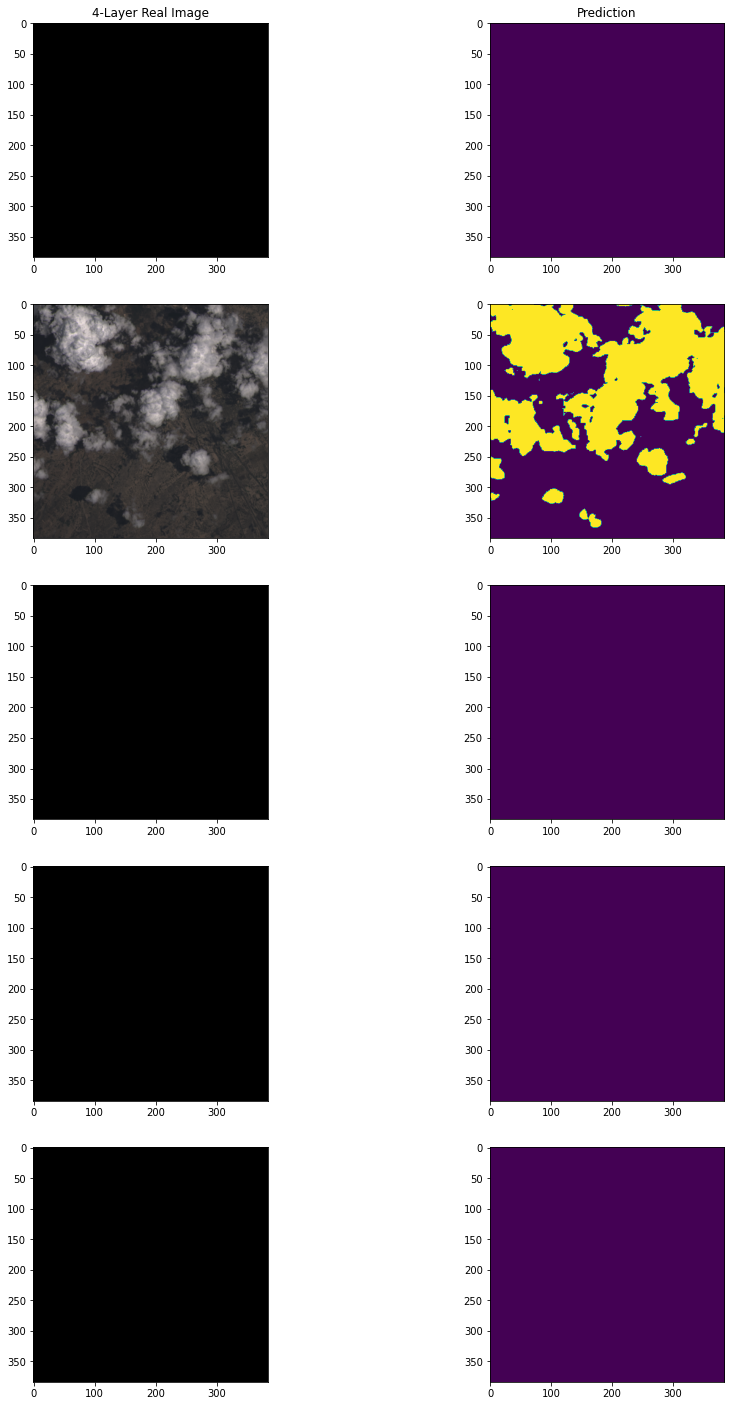

In [21]:
xb = next(itertools.islice(iter(dataloaders['test']), 3))

with torch.no_grad():
    predb = model(xb.cuda())

fig, ax = plt.subplots(batch_size,2, figsize=(15,batch_size*5))
ax[0][0].set_title('4-Layer Real Image')
ax[0][1].set_title('Prediction')
for i in range(batch_size):
    ax[i,0].imshow(batch_to_img(xb,i))
    ax[i,1].imshow(predb_to_mask(predb, i))